# Mandelbrot

In [1]:
import io
import imageio

import numpy as np
import matplotlib.pyplot as plt

from numba import jit, njit, prange
from PIL import Image

In [2]:
def calc_z(x, y, max_iters, limit=100):
    C = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + C
        if (z.real*z.real + z.imag*z.imag) >= limit:
            return i
    return max_iters

def julia_set(min_x, max_x, min_y, max_y, size, iters, limit):
    image = np.zeros((size, size), dtype=np.uint16)
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in prange(width):
        real = min_x + x * pixel_size_x
        for y in prange(height):
            imag = min_y + y * pixel_size_y
            color = calc_z(real, imag, iters)
            image[y, x] = color
    return image

In [3]:
@njit(fastmath=True)
def calc_z_jit(x, y, max_iters, limit=100):
    C = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + C
        if np.sqrt(z.real*z.real + z.imag*z.imag) >= limit:
            return i
    return max_iters

@njit(parallel=True, fastmath=True)
def julia_set_jit(min_x, max_x, min_y, max_y, size, iters, limit):
    image = np.zeros((size, size), dtype=np.uint16)
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height

    for x in prange(width):
        real = min_x + x * pixel_size_x
        for y in prange(height):
            imag = min_y + y * pixel_size_y
            color = calc_z_jit(real, imag, iters)
            image[y, x] = color
    return image

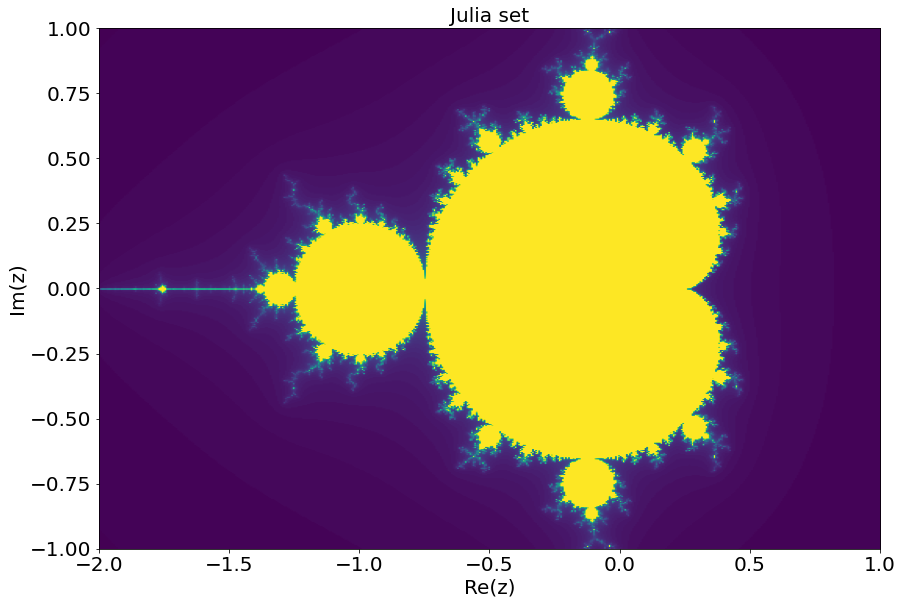

In [4]:
julia = julia_set_jit(-2.0, 1.0, -1.0, 1.0, 500, 100, 100)

plt.figure(figsize=(14, 11))
plt.imshow(julia, extent=(-2, 1, -1, 1))
plt.title('Julia set', fontsize=20)
plt.xlabel('Re(z)', fontsize=20)
plt.ylabel('Im(z)', fontsize=20)
plt.tick_params(labelsize=20)

In [5]:
import cProfile

cProfile.run('julia_set_jit(-2.0, 1.0, -1.0, 1.0, 500, 100, 100)')

         5 function calls in 0.015 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.015    0.015    0.015    0.015 613359336.py:11(julia_set_jit)
        1    0.000    0.000    0.015    0.015 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 serialize.py:29(_numba_unpickle)
        1    0.000    0.000    0.015    0.015 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [6]:
steps = np.arange(1, 1001, 100)

In [7]:
time_np = np.zeros(steps.size)
time_jit = np.zeros(steps.size)
for i, step in enumerate(steps):
    print(f'\r{i+1}/{steps.size}', end='')
    time = %timeit -o -q -r 10 -n 3 julia_set(-2.0, 1.0, -1.0, 1.0, 500, step, 100)
    time_np[i] = time.best

    time = %timeit -o -q -r 10 -n 3 julia_set_jit(-2.0, 1.0, -1.0, 1.0, 500, step, 100)
    time_jit[i] = time.best

10/10

Text(0, 0.5, 'Computation time')

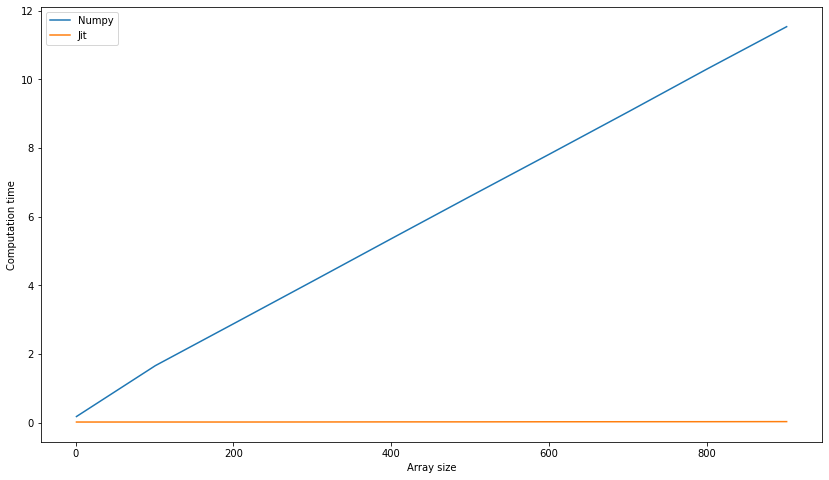

In [8]:
plt.figure(figsize=(14, 8))
plt.plot(steps, time_np, label='Numpy')
plt.plot(steps, time_jit, label='Jit')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computation time')

# N-body problem

In [9]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * np.random.random()
        self.y = domain * np.random.random()
        self.z = domain * np.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [10]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

In [11]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [12]:
particle_dtype = np.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double, 
                                        np.double]})

In [13]:
@njit
def create_n_random_particles(n, m, domain=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = np.zeros((n), dtype=particle_dtype)

    for p in parts:
        p['m'] = m
        p['phi'] = 0.
        p['x'] = domain * np.random.random()
        p['y'] = domain * np.random.random()
        p['z'] = domain * np.random.random()
        
    return parts   #parts is an array of particles

In [14]:
parts = create_n_random_particles(1000, .001, 1)

In [15]:
@njit
def distance(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1['x'] - part2['x'])**2 + 
            (part1['y'] - part2['y'])**2 + 
            (part1['z'] - part2['z'])**2)**.5

In [16]:
distance(parts[0], parts[1])

0.5148852205189893

In [17]:
@njit
def direct_sum_np(particles):
    for i, target in enumerate(particles):
        for j, source in enumerate(particles):
            if j == i:
                continue
            r = distance(target, source)
            target['phi'] += source['m'] / r

In [18]:
direct_sum_np(parts)

In [19]:
array_of_sizes = np.arange(100, 2001, 100)

In [20]:
time_arr = np.zeros(array_of_sizes.size)
time_arr_np = np.zeros(array_of_sizes.size)
for i, size in enumerate(array_of_sizes):
    print(f'\r{i+1}/{array_of_sizes.size}', end='')
    parts = [Particle(m=1) for i in range(size)]
    parts_np = create_n_random_particles(size, .001, 1)
    
    time = %timeit -o -q -r 3 -n 5 direct_sum(parts)
    time_arr[i] = time.best
    
    time = %timeit -o -q -r 3 -n 5 direct_sum_np(parts_np)
    time_arr_np[i] = time.best

20/20

Text(0, 0.5, 'Computation time')

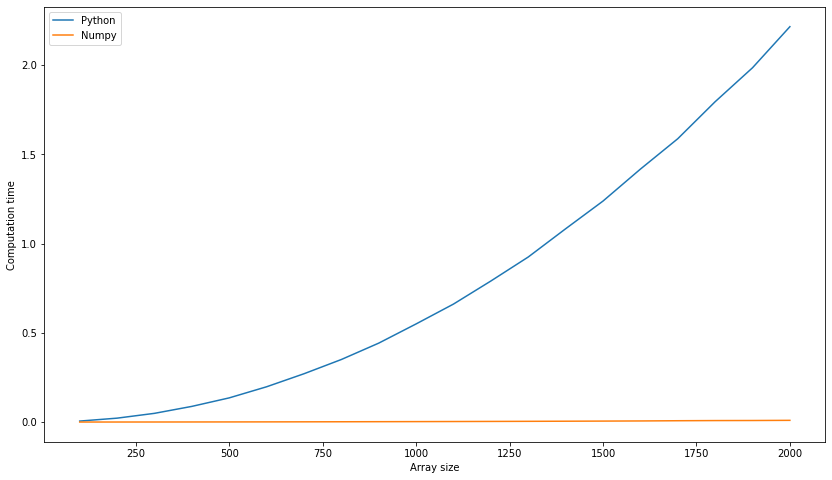

In [21]:
plt.figure(figsize=(14, 8))
plt.plot(array_of_sizes, time_arr, label='Python')
plt.plot(array_of_sizes, time_arr_np, label='Numpy')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computation time')